# Quora Question Pair Similarity Solution

## 1. EDA

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

## 1.1 Loading Data

In [2]:
data_path = '/home/monodeepdas112/Datasets/quora-questions-sim/questions.csv'

df = pd.read_csv(data_path)

print("Number of data points : ", df.shape[0])

Number of data points :  404351


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
id              404351 non-null int64
qid1            404351 non-null int64
qid2            404351 non-null int64
question1       404350 non-null object
question2       404349 non-null object
is_duplicate    404351 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

## 1.2.1 Distribution of data points among output classes

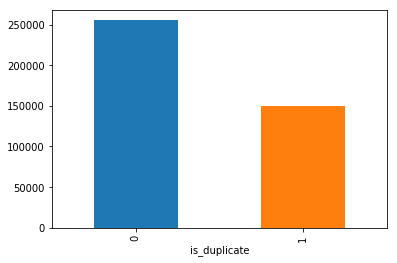

In [5]:
df.groupby("is_duplicate")["id"].count().plot.bar()

In [6]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404351


In [7]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


## 1.2.2 Number of unique questions

In [8]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 789801

Number of unique questions that appear more than one time: 13698 (1.7343609339567814%)

Max number of times a single question is repeated: 50



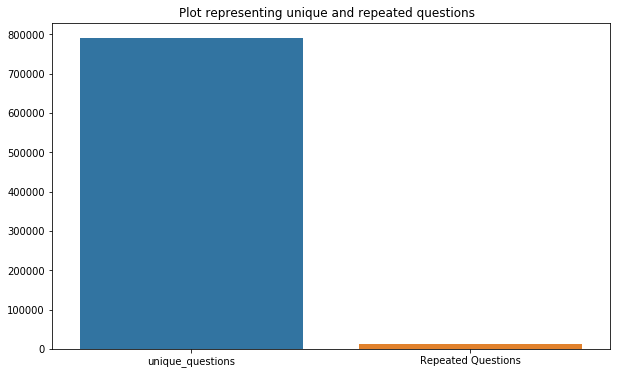

In [9]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

## 1.2.3 Checking for Duplicates

In [10]:
pair_uniques = df[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

In [11]:
print("Number of duplicate questions", df.shape[0] - (pair_uniques).shape[0])

Number of duplicate questions 3


#### Removing duplicates from the dataframe

In [12]:
df = df.drop_duplicates(subset=['qid1', 'qid2', 'is_duplicate'])

In [13]:
print("The new number of records : ", df.shape[0])

The new number of records :  404349


## 1.2.4 Number of occurrences of each question

Maximum number of times a single question is repeated: 50



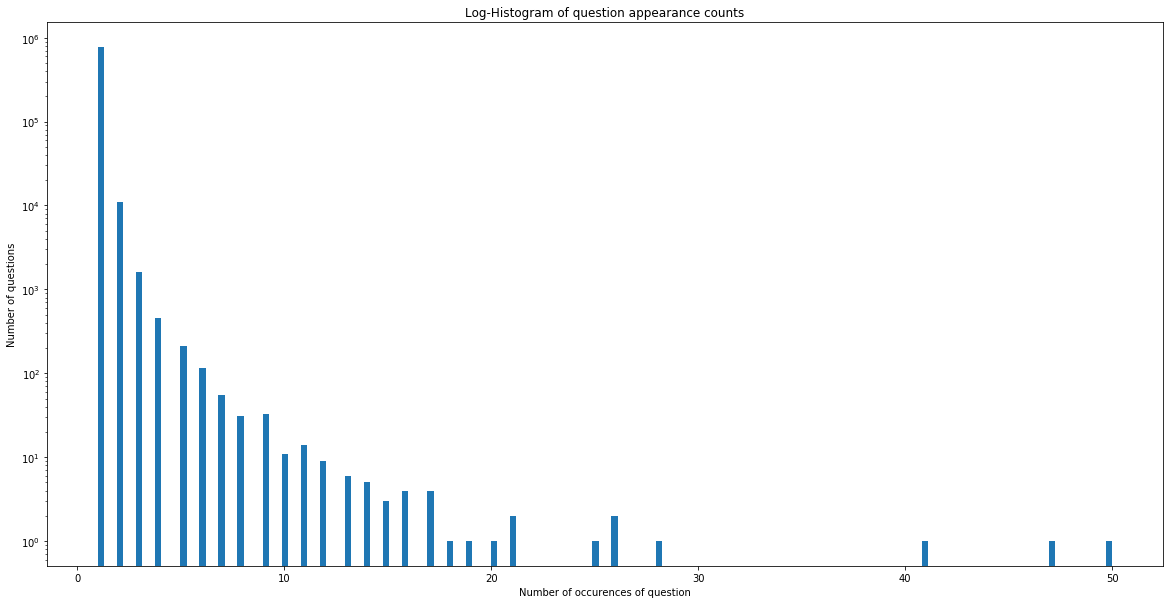

In [14]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

## 1.2.5 Checking for NULL values

In [15]:
# Checking for null values in any rows
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105796  105796  209841  209842    How can I develop android app?   
201871  201871  398348  398349  How can I create an Android app?   
363416  363416  711434  711435                               NaN   

                                                question2  is_duplicate  
105796                                                NaN             0  
201871                                                NaN             0  
363416  My Chinese name is Haichao Yu. What English na...             0  


- There are 3 rows with null values in question2

- Filling the null values with ' '

In [16]:
df = df.fillna('')
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## 1.3 Basic Feature Extraction (before cleaning)

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [17]:
def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

data_path = '/home/monodeepdas112/Datasets/quora-questions-sim/questions_unpreprocessed_train.csv'

if os.path.isfile(data_path):
    df = pd.read_csv(data_path, encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
    
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)
    
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)
    
    df['word_share'] = df.apply(normalized_word_share, axis=1)
    
    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
    
    
    df.to_csv(data_path, index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


## 1.3.1 Analysis of some of the extracted features

- Here are some questions have only one single words.

In [21]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 60
Number of Questions with minimum length [question2] : 25


#### 1.3.1.1 Feature: word_share

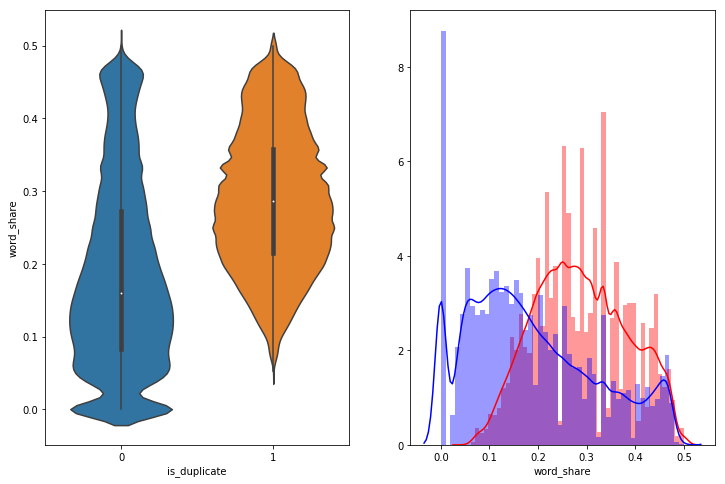

In [22]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

#### 1.3.1.2 Feature: word_Common

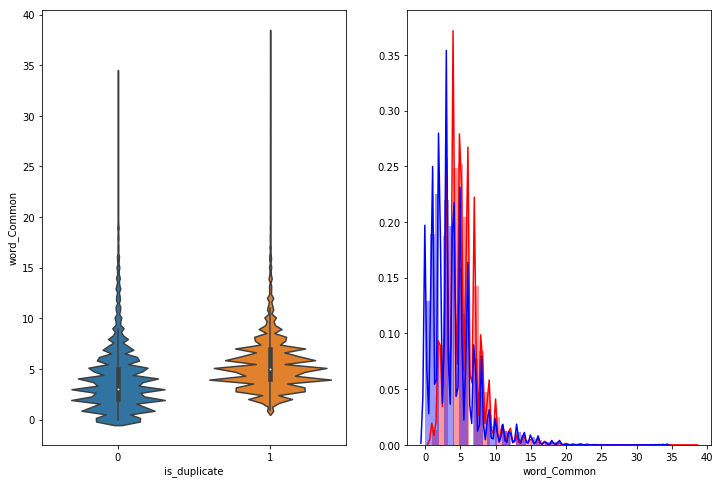

In [23]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

## 1.4 EDA: Advanced Feature Extraction

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [25]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile(data_path):
    df = pd.read_csv(data_path, encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get {0} from drive or run the previous notebook".format(data_path))

In [26]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0


### 1.4.1 Preprocessing of Text

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [27]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
    
    return x

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

## 1.5 Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [28]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [29]:
data_path = '/home/monodeepdas112/Datasets/quora-questions-sim/nlp_features_train.csv'
train_csv = '/home/monodeepdas112/Datasets/quora-questions-sim/questions.csv'
if os.path.isfile(data_path):
    df = pd.read_csv(data_path, encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv(train_csv)
    df = extract_features(df)
    df.to_csv(data_path, index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


### 1.5.1 Analysis of extracted features

#### 1.5.1.1 Plotting Word clouds

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [30]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298612
Number of data points in class 0 (non duplicate pairs) : 510090


In [31]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16114225
Total number of words in non duplicate pair questions : 33201620


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


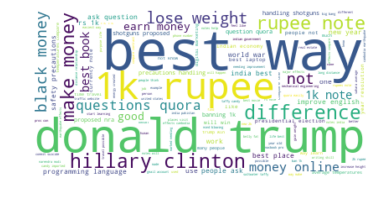

In [32]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


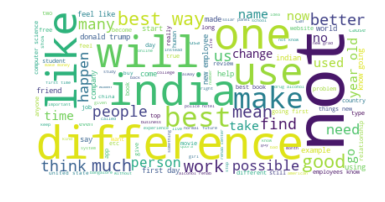

In [33]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 1.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

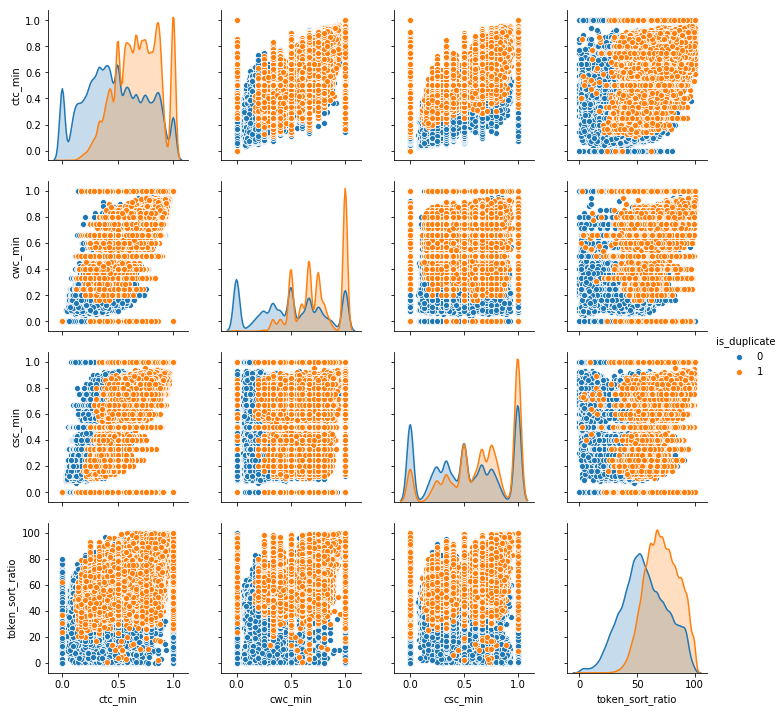

In [34]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

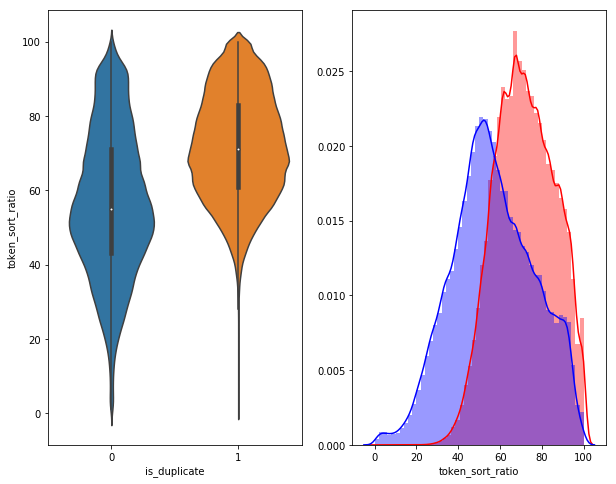

In [35]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

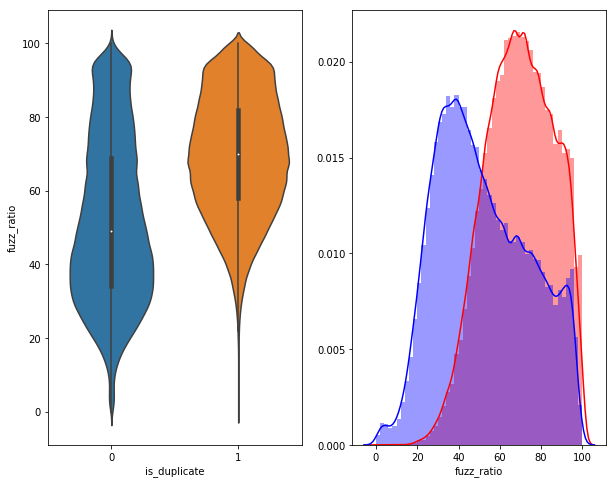

In [36]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

### 1.5.2 Visualization

In [37]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [38]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.050s...
[t-SNE] Computed neighbors for 5000 samples in 0.517s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130416
[t-SNE] Computed conditional probabilities in 0.339s
[t-SNE] Iteration 50: error = 82.1324539, gradient norm = 0.0373448 (50 iterations in 3.727s)
[t-SNE] Iteration 100: error = 70.6826782, gradient norm = 0.0097551 (50 iterations in 2.404s)
[t-SNE] Iteration 150: error = 68.8895721, gradient norm = 0.0050813 (50 iterations in 2.777s)
[t-SNE] Iteration 200: error = 68.0909195, gradient norm = 0.0039069 (50 iterations in 3.306s)
[t-SNE] Iteration 250: error = 67.6059952, gradient norm = 0.0034114

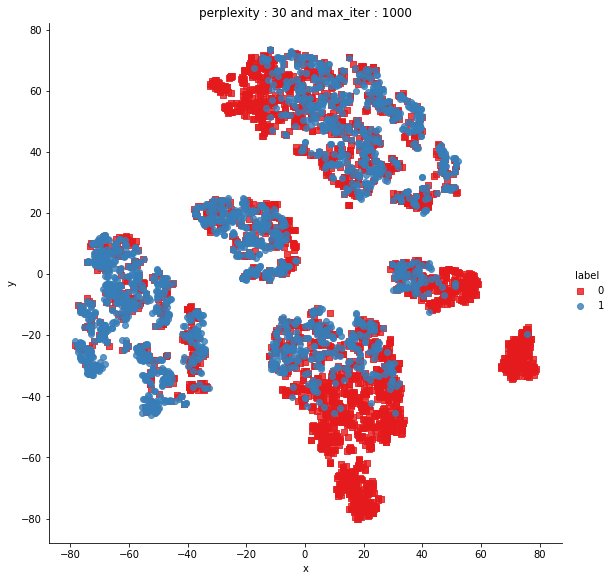

In [39]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [40]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.018s...
[t-SNE] Computed neighbors for 5000 samples in 0.598s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130416
[t-SNE] Computed conditional probabilities in 0.289s
[t-SNE] Iteration 50: error = 83.4871674, gradient norm = 0.0418441 (50 iterations in 13.768s)
[t-SNE] Iteration 100: error = 69.5311432, gradient norm = 0.0037575 (50 iterations in 6.333s)
[t-SNE] Iteration 150: error = 68.0535889, gradient norm = 0.0019076 (50 iterations in 5.724s)
[t-SNE] Iteration 200: error = 67.4689713, gradient norm = 0.0012589 (50 iterations in 5.592s)
[t-SNE] Iteration 250: error = 67.1411362, gradient norm = 0.000961

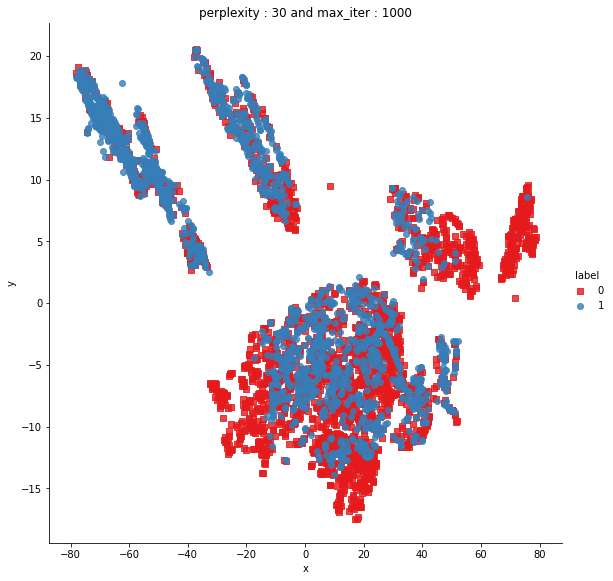

In [41]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne3d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [42]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

## 2 Featurizing text data with tfidf weighted word-vectors

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [64]:
# avoid decoding problems
data_path = '/home/monodeepdas112/Datasets/quora-questions-sim/questions_unpreprocessed_train.csv'
df = pd.read_csv(data_path)
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [65]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


In [66]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import CountVectorizer
# # merge texts
# questions = list(df['question1']) + list(df['question2'])

# tfidf = TfidfVectorizer(lowercase=False)
# tfidf.fit_transform(questions)

# # dict key:word and value:tf-idf score
# word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

#### - After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [67]:
# nlp = spacy.load('en')

# vecs1 = []
# # https://github.com/noamraph/tqdm
# # tqdm is used to print the progress bar
# for qu1 in tqdm(list(df['question1'])):
#     doc1 = nlp(qu1) 
#     # 384 is the number of dimensions of vectors 
#     mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
#     for word1 in doc1:
#         # word2vec
#         vec1 = word1.vector
#         # fetch df score
#         try:
#             idf = word2tfidf[str(word1)]
#         except:
#             idf = 0
#         # compute final vec
#         mean_vec1 += vec1 * idf
#     mean_vec1 = mean_vec1.mean(axis=0)
#     vecs1.append(mean_vec1)
# df['q1_feats_m'] = list(vecs1)

In [68]:
# vecs2 = []
# for qu2 in tqdm(list(df['question2'])):
#     doc2 = nlp(qu2) 
#     mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
#     for word2 in doc2:
#         # word2vec
#         vec2 = word2.vector
#         # fetch df score
#         try:
#             idf = word2tfidf[str(word2)]
#         except:
#             #print word
#             idf = 0
#         # compute final vec
#         mean_vec2 += vec2 * idf
#     mean_vec2 = mean_vec2.mean(axis=0)
#     vecs2.append(mean_vec2)
# df['q2_feats_m'] = list(vecs2)

In [69]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
nl_data_csv = '/home/monodeepdas112/Datasets/quora-questions-sim/nlp_features_train.csv'
if os.path.isfile(nl_data_csv):
    dfnlp = pd.read_csv(nl_data_csv, encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

un_pre_pro_csv = '/home/monodeepdas112/Datasets/quora-questions-sim/questions_unpreprocessed_train.csv'
if os.path.isfile(un_pre_pro_csv):
    dfppro = pd.read_csv(un_pre_pro_csv, encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [70]:
dfnlp.columns.tolist()

['id',
 'qid1',
 'qid2',
 'question1',
 'question2',
 'is_duplicate',
 'cwc_min',
 'cwc_max',
 'csc_min',
 'csc_max',
 'ctc_min',
 'ctc_max',
 'last_word_eq',
 'first_word_eq',
 'abs_len_diff',
 'mean_len',
 'token_set_ratio',
 'token_sort_ratio',
 'fuzz_ratio',
 'fuzz_partial_ratio',
 'longest_substr_ratio']

In [72]:
# df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
# df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
# df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
# df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
# df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [73]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [74]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


In [75]:
# # Questions 1 tfidf weighted word2vec
# df3_q1.head()

In [ ]:
# # Questions 2 tfidf weighted word2vec
# df3_q2.head()

In [76]:
# print("Number of features in nlp dataframe :", df1.shape[1])
# print("Number of features in preprocessed dataframe :", df2.shape[1])
# print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
# print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
# print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

In [77]:
# storing the final features to csv file
final_feat = '/home/monodeepdas112/Datasets/quora-questions-sim/final_features.csv'
if not os.path.isfile(final_feat):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv(final_feat)
else:
    result = pd.read_csv(final_feat)

In [78]:
result.columns.tolist()

['Unnamed: 0',
 'id',
 'is_duplicate',
 'cwc_min',
 'cwc_max',
 'csc_min',
 'csc_max',
 'ctc_min',
 'ctc_max',
 'last_word_eq',
 'first_word_eq',
 'abs_len_diff',
 'mean_len',
 'token_set_ratio',
 'token_sort_ratio',
 'fuzz_ratio',
 'fuzz_partial_ratio',
 'longest_substr_ratio',
 'freq_qid1',
 'freq_qid2',
 'q1len',
 'q2len',
 'q1_n_words',
 'q2_n_words',
 'word_Common',
 'word_Total',
 'word_share',
 'freq_q1+q2',
 'freq_q1-q2',
 '0_x',
 '1_x',
 '2_x',
 '3_x',
 '4_x',
 '5_x',
 '6_x',
 '7_x',
 '8_x',
 '9_x',
 '10_x',
 '11_x',
 '12_x',
 '13_x',
 '14_x',
 '15_x',
 '16_x',
 '17_x',
 '18_x',
 '19_x',
 '20_x',
 '21_x',
 '22_x',
 '23_x',
 '24_x',
 '25_x',
 '26_x',
 '27_x',
 '28_x',
 '29_x',
 '30_x',
 '31_x',
 '32_x',
 '33_x',
 '34_x',
 '35_x',
 '36_x',
 '37_x',
 '38_x',
 '39_x',
 '40_x',
 '41_x',
 '42_x',
 '43_x',
 '44_x',
 '45_x',
 '46_x',
 '47_x',
 '48_x',
 '49_x',
 '50_x',
 '51_x',
 '52_x',
 '53_x',
 '54_x',
 '55_x',
 '56_x',
 '57_x',
 '58_x',
 '59_x',
 '60_x',
 '61_x',
 '62_x',
 '63_x',


<h2> 4.2 Converting strings to numerics </h2>

In [79]:
result.drop(result.index[0], inplace=True)
y_true = result.is_duplicate
result.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [80]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(result.columns)
for i in cols:
    result[i] = result[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [81]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

<h2> 4.3 Random train test split( 70:30) </h2>

In [82]:
X_train,X_test, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.3)

In [83]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283045, 218)
Number of data points in test data : (121305, 218)


In [84]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6307512939638573 Class 1:  0.3692487060361427
---------- Distribution of output variable in train data ----------
Class 0:  0.369251061374222 Class 1:  0.369251061374222


In [85]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8882878002916775


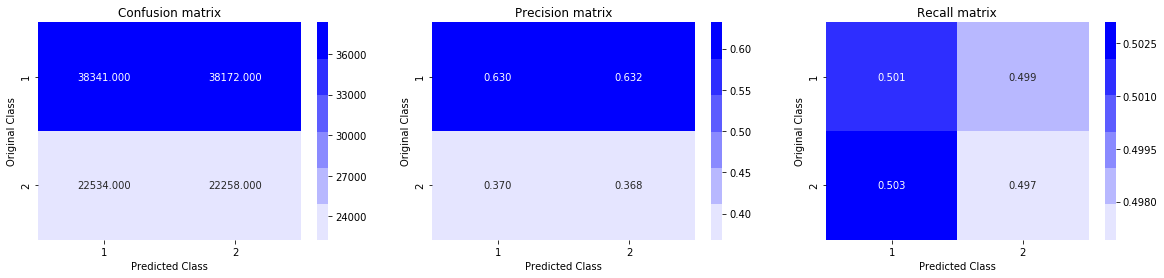

In [86]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

In [87]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<h2> 4.6 XGBoost </h2>

In [ ]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [ ]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


In [4]:
from sklearn.pipeline import Pipeline

In [5]:
# Loading the nlp features
data_path = '/home/monodeepdas112/Datasets/quora-questions-sim/nlp_features_train.csv'
data = pd.read_csv(data_path, encoding='latin-1')

In [6]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [187]:
num_data_pts = 1000

In [188]:
Y = data.loc[:num_data_pts,'is_duplicate']

In [189]:
X = data.loc[:num_data_pts, ['question1', 'question2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio']]

In [190]:
Dx_train, Dx_test, Dy_train, Dy_test = train_test_split(X, Y, test_size=0.30, random_state=42)

### [5.0.1] Defining some functions to increase code reusability and readability

In [399]:
class CustomVectorizer:
    def __init__(self, max_feats = None):
        if max_feats is not None:
            self.tfidf = TfidfVectorizer(lowercase=False, max_features=max_feats)
        else:
            self.tfidf = TfidfVectorizer(lowercase=False)
    
    def fit(self, X:np.array):
        b = np.vstack((X[:, :1], X[:, 1:2]))
        c = b[:, :1].tolist()
        c = [i[0] for i in c]
        self.tfidf.fit(c)
        return self
    
    def transform(self, X:np.array):
        q1_feats = np.array(self.tfidf.transform([i[0] for i in X[:, :1]]).todense())
        q2_feats = np.array(self.tfidf.transform([i[0] for i in X[:, 1:2]]).todense())
        nlp_feats = np.array([X[i][2:] for i in range(X.shape[0])])
        return np.hstack((nlp_feats, q1_feats, q2_feats))        

In [400]:
def get_vectorizer(vectorizer:str, train:np.array):
    if(vectorizer=='TFIDF'):
        vectorizer = CustomVectorizer()
    vectorizer.fit(train)
    return vectorizer

In [406]:
def perform_grid_search_cv_svm(X:pd.core.frame.DataFrame, Y:pd.core.frame.DataFrame, vectorizer, path):

    results_path = '{0}/cv_results.csv'.format(path)
    if(os.path.exists(results_path)):
        #if present simply load the model
        return pd.read_csv(results_path)
    else:
        # else perform hyperparameter tuning
        print('Performing Hyperparameter Tuning...\n')
        # regularization parameter
        alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
        penalty = ['l1', 'l2']
        hyperparameters = {
            'svm__penalty' : penalty,
            'svm__alpha' : alpha
        }

        penalties = []
        alpha_values = []

        train_scores = []
        test_scores = []

        train_mean_score = []
        test_mean_score = []

        # Initializing KFold
        skf = StratifiedKFold(n_splits=3)
        X = np.array(X)
        Y = np.array(Y)
        for reg_param in hyperparameters['svm__alpha']:
            for penalty in hyperparameters['svm__penalty']:
                
                #Performing Cross Validation
                for train_index, test_index in skf.split(X, Y):
                    Dx_train, Dx_cv = X[train_index], X[test_index]
                    Dy_train, Dy_cv = Y[train_index], Y[test_index]

                    #Initializing the Vectorizer
                    vectorizer = get_vectorizer('TFIDF', Dx_train)

                    #Transforming the data to features
                    x_train = vectorizer.transform(Dx_train)
                    x_cv = vectorizer.transform(Dx_cv)

                    #Initializing the LR model        
                    svm = SGDClassifier(penalty=penalty, 
                                        alpha=reg_param, 
                                        max_iter=1000, verbose=0)

                    # Fit the model
                    svm.fit(x_train, Dy_train)

                    # Calibrating the svm model to output probablity class labels
                    calib_svm = CalibratedClassifierCV(base_estimator=svm, method="isotonic", cv="prefit")
                    calib_svm.fit(x_train, Dy_train)
                    
                    #Prediction
                    train_results = calib_svm.predict_proba(x_train)
                    cv_results = calib_svm.predict_proba(x_cv)

                    try:
                        train_score = log_loss(Dy_train, train_results[:, 1])
                        test_score = log_loss(Dy_cv, cv_results[:, 1])

                        #storing the results to form a dataframe
                        train_scores.append(train_score)
                        test_scores.append(test_score)

                    except Exception as e:
                        print('Error Case : ', e)
                        print(('Actual, Predicted'))
                        [print((Dy_cv[i], cv_results[i, 1])) for i in range(len(Dy_cv))]
                    
                    print('CV iteration : alpha={0}, penalty={1}, train_score={2}, test_score={3}'
                      .format(reg_param, penalty, train_score, test_score))

                train_mean_score.append(sum(train_scores)/len(train_scores))
                test_mean_score.append(sum(test_scores)/len(test_scores))

                penalties.append(penalty)
                alpha_values.append(reg_param)

                print('C={0}, penalty={1}, train_score={2}, test_score={3}'
                      .format(reg_param, penalty, sum(train_scores)/len(train_scores), sum(test_scores)/len(test_scores)))

                train_scores = []
                test_scores = []
        
        # Creating a DataFrame from the saved data for visualization
        results_df = pd.DataFrame({'alpha' : alpha_values, 'penalty' : penalties, 
                                   'train_score' : train_mean_score, 
                                   'test_score': test_mean_score})
        
        #writing the results to csv after performing hyperparameter tuning
        results_df.to_csv(results_path)
        
        return results_df

In [407]:
path = 'saved_models'
perform_grid_search_cv_svm(Dx_train, Dy_train, 'TFIDF', path)



  0%|          | 0/9 [00:00<?, ?it/s]

Performing Hyperparameter Tuning...

CV iteration : alpha=0.0001, penalty=l1, train_score=0.3434340797914279, test_score=2.34379751190614
CV iteration : alpha=0.0001, penalty=l1, train_score=0.4010899382208684, test_score=1.1497735332385495


KeyboardInterrupt: 

In [152]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
# print(vectorizer.get_feature_names())

a = pd.DataFrame({'q1': [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
], 
                  'q2': [
    'This is a document.',
    'Get me a white sheet please!',
    'And this is the third right?',
    'Is this the second document?',
]})
vectorizer.fit(list(a['q1'])+list(a['q2']))
X = vectorizer.transform(a['q1'].values)
Y = vectorizer.transform(a['q2'].values)
print(X.todense().shape)
print(Y.todense().shape)

(4, 15)
(4, 15)
